In [3]:
%matplotlib inline

In [4]:
import numpy as np
import scipy.optimize as spo
import scipy.io as sio
import time
import matplotlib.pyplot as plt

In [5]:
def sigmoid(x):
    """ Evaluate the sigmoid function on an np.array. This uses the classic exponential sigmoid, sig(x) = 1/(1 + e^-x)
    
        Keyword Arguments:
        x -- an np.array.
    """
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_gradient(x):
    """ Evaluate the sigmoid gradient (i.e. the derivative of the sigmoid function).
        Recall that d(sig(x))/dx = sig(x) * (1 - sig(x)) for an exponential sigmoid.
        
        
        Keyword Arguments:
        x -- an np.array
    """
    q = sigmoid(x)
    return q * (1 - q)

In [6]:
def cost_function(nn_params, il_size, hl_size, num_labels, X, y, lam):
#     print('evaluating cost function')
    """ Evaluate the cost function for a layer of a backpropogated neural net.
    
        Keyword Arguments:
        
        nn_params -- A rolled-up np.array containing the theta parameters of the net.
        il_size -- The input layer size.
        hl_size -- The hidden layer size.
        num_labels -- The number of output neurons, i.e. the output layer size
        X -- Feature matrix, with training examples in rows
        y -- Label vector, corresponding to output neurons 1 ... num_labels
        lam -- regularization parameter
    """
    split_indx = hl_size * (il_size + 1);
    
#     print(split_indx)
#     print(len(nn_params[0:split_indx]))

    Theta1 = np.reshape(nn_params[0:split_indx], [hl_size, il_size + 1])
    Theta2 = np.reshape(nn_params[split_indx:] , [num_labels, hl_size + 1] )
    
#     print(Theta1.shape)
#     print(Theta2.shape)

    m = X.shape[0]

    J = 0
    
    K = num_labels
    for i in range(0,m):
        # Forward propogation
        a_1 = np.insert(X[i,:], 0, 1)
        
        z_2 = np.dot(Theta1, a_1)
        a_2 = np.insert(sigmoid(z_2), 0, 1)
        
        z_3 = np.dot(Theta2, a_2)
        a_3 = sigmoid(z_3)
        
        yvec = np.zeros([num_labels,1])
        yvec[y[i]-1] = 1;
        
        term1 = np.dot( np.transpose(-1 * yvec), np.log(a_3))
        term2 = np.dot( np.transpose(1 - yvec) , np.log(1 - a_3) )

        J = J + np.sum( term1 - term2);
        
        Theta1_temp = Theta1[:,1:]
        Theta2_temp = Theta2[:,1:]
        regterm = (lam / (2 * m)) * (np.sum(np.power(Theta1_temp.flatten(),2)) + np.sum(np.power(Theta2_temp.flatten(),2)))
        J = J + regterm
    return J/m

In [7]:
def jacobian(nn_params, il_size, hl_size, num_labels, X, y, lam):
#     print("evaluating jacobian")
    """ Evaluate the Jacobian (i.e. gradient) for a layer of a backpropogated neural net.
    
        Keyword Arguments:
        
        nn_params -- A rolled-up np.array containing the theta parameters of the net.
        il_size -- The input layer size.
        hl_size -- The hidden layer size.
        num_labels -- The number of output neurons, i.e. the output layer size
        X -- Feature matrix, with training examples in rows
        y -- Label vector, corresponding to output neurons 1 ... num_labels
        lam -- regularization parameter
    """
    split_indx = hl_size * (il_size + 1);
    
    m = X.shape[0]
    
    Theta1 = np.reshape(nn_params[0:split_indx], [hl_size, il_size + 1])
    Theta2 = np.reshape(nn_params[split_indx:] , [num_labels, hl_size + 1] )
    
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    Delta_1 = np.zeros(Theta1.shape)
    Delta_2 = np.zeros(Theta2.shape)
    for i in range(0,m):
        # Forward propogation
        a_1 = np.insert(X[i,:], 0, 1)
        a_1.shape = (il_size + 1, 1)
        
        z_2 = np.dot(Theta1, a_1)
        a_2 = np.insert(sigmoid(z_2), 0, 1)
        a_2.shape = (hl_size + 1, 1)
        
        z_3 = np.dot(Theta2, a_2)
        a_3 = sigmoid(z_3)
        a_3.shape = (num_labels,1)
        yvec = np.zeros([num_labels,1])
        yvec[y[i]-1] = 1;
                
        d_3 = a_3 - yvec
        siggrad = sigmoid_gradient(z_2).flatten()
        siggrad.shape = (hl_size,1)

        d_2 = np.multiply(np.dot(np.transpose(Theta2[:,1:]), d_3), siggrad)
        
#         print(Delta_2.shape)
#         print(np.dot(d_3, np.transpose(a_2)).shape)
#         print(Delta_1.shape)
#         print(d_2.shape)
#         print(np.transpose(a_1).shape)
#         print(np.dot(d_2, np.transpose(a_1)).shape)
        Delta_2 = Delta_2 + np.dot(d_3, np.transpose(a_2))
        Delta_1 = Delta_1 + np.dot(d_2, np.transpose(a_1))
    
    Theta1_grad = Delta_1 * 1/m;
    Theta2_grad = Delta_2 * 1/m;
    
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + lam/m * Theta1[:,1:]
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + lam/m * Theta2[:,1:]
    t1 = Theta1_grad.flatten()
    t2 = Theta2_grad.flatten()
    
    return np.concatenate([t1, t2])

In [8]:
def rand_init_weights(lin, lout):
    epsilon_init = .1;
    W = np.random.randn(lout, 1 + lin) * epsilon_init;
    return W

In [9]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    h1 = X;
    h1 = np.c_[np.ones([X.shape[0],1]), X]
    h1 = np.dot(h1, np.transpose(Theta1))
    h2 = h1;
    h2 = np.c_[np.ones([X.shape[0],1]), h1]
    h2 = np.dot(h2, np.transpose(Theta2))
    
    return h2.argmax(axis = 1)

In [10]:
# Load the data
d = sio.loadmat(file_name='ex4data1.mat')

In [98]:
# "Live" Section
INPUT_LAYERS = 400
HIDDEN_LAYERS = 25
OUTPUT_LAYERS = 10

OPTIM_MAX_ITER = 50

#Gather data for learning curves

optim_times = []
cv_error_vector = []
training_error_vector = []
training_examples_vector = []

training_results_vector = []

TT0 = time.time()
trainfracs_tests = np.linspace(start = .05, stop = .6, num = 15)
for trainfrac in trainfracs_tests:
    print("Testing training fraction " + str(trainfrac) + "...")
    t0 = time.time()

    X = d['X']
    np.random.seed(1234)
    np.random.shuffle(X)

    y = d['y']
    np.random.seed(1234)
    np.random.shuffle(y)
    TRAIN_FRACTION = trainfrac
    CV_FRACTION = min(trainfrac, .2)
    TEST_FRACTION = .2

    X_train = X[0:int(np.floor(X.shape[0] * TRAIN_FRACTION)),:]
    y_train = y[0:int(np.floor(y.shape[0] * TRAIN_FRACTION)),:]

    X_cv = X[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]
    y_cv = y[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]

    X_test = X[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]
    y_test = y[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]

    init_theta1 = rand_init_weights(INPUT_LAYERS, HIDDEN_LAYERS).flatten()
    init_theta2 = rand_init_weights(HIDDEN_LAYERS, OUTPUT_LAYERS).flatten()

    init_params = np.concatenate([init_theta1, init_theta2])

    lam = .01

    params = (INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS, X_train, y_train, lam)

    opts = {'disp':True, 'maxiter':OPTIM_MAX_ITER}

    print("Starting optimization...")
    res = spo.minimize(cost_function, init_params, method = 'CG', jac = jacobian, args = params, tol = 1e-4, options = opts)
    print("Finished optimization.")
    training_results_vector.append(res)
#         print("Optimization for " + str(OPTIM_MAX_ITER) + " iteration took " + str(total_time))

    theta_out = res['x']

    split_indx = HIDDEN_LAYERS * (INPUT_LAYERS + 1);

    Theta1 = np.reshape(theta_out[0:split_indx], [HIDDEN_LAYERS, INPUT_LAYERS + 1])
    Theta2 = np.reshape(theta_out[split_indx:] , [OUTPUT_LAYERS, HIDDEN_LAYERS + 1] )

    # Calculate the training error
    preds_train = predict(Theta1, Theta2, X_train) + 1
    correct = 0;
    total = len(y_train);
    for k in range(0,len(y_train)):
        predic = preds_train[k]
        acts = y_train[k]
        if predic == acts:
            correct += 1
    err_train = 1 - correct/total
    training_error_vector.append(err_train)
    print("Training error: " + str(err_train))
    
    # Calculate the cross validation error
    preds_cv = predict(Theta1, Theta2, X_cv) + 1
    correct = 0;
    total = len(y_cv);
    for k in range(1,len(y_cv)):
        predic = preds_cv[k]
        acts = y_cv[k]
        if predic == acts:
            correct += 1
    err_cv = 1 - correct/total
    cv_error_vector.append(err_cv)
    print("Cross Validation error: " + str(err_cv))
    
    t1 = time.time()
    total_time = t1 - t0
    x_len = len(X_train)
    print("Took " + str(total_time) + " seconds")
    print("\n")
    optim_times.append(total_time)
    training_examples_vector.append(x_len)



TT1 = time.time()
print("Time for learning curves exploration: " + str(TT1 - TT0))

Testing training fraction 0.05...
Starting optimization...
         Current function value: 0.040188
         Iterations: 50
         Function evaluations: 154
         Gradient evaluations: 154
Finished optimization.
Training error: 0.016000000000000014
Cross Validation error: 0.18000000000000005
Took 21.647434949874878 seconds


Testing training fraction 0.0892857142857...
Starting optimization...
         Current function value: 0.035366
         Iterations: 50
         Function evaluations: 139
         Gradient evaluations: 139
Finished optimization.
Training error: 0.0358744394618834
Cross Validation error: 0.179372197309417
Took 35.022398948669434 seconds


Testing training fraction 0.128571428571...
Starting optimization...
         Current function value: 0.039077
         Iterations: 50
         Function evaluations: 125
         Gradient evaluations: 125
Finished optimization.
Training error: 0.09657320872274144
Cross Validation error: 0.16640746500777603
Took 44.81327009201

In [81]:
train_error_vector_lam = []
cv_error_vector_lam = []
optim_times_lam = []
lamchoices = [0, .0001, .0003, .001, .003, .01, .03, .1, .3, 1, 3]

reg_results = []


for lamex in lamchoices:
    print("Testing lambda = " + str(lamex) + "...")
    t0 = time.time()
#     try:
    X = d['X']
    np.random.seed(1234)
    np.random.shuffle(X)

    y = d['y']
    np.random.seed(1234)
    np.random.shuffle(y)

    TRAIN_FRACTION = .6
    CV_FRACTION = .2
    TEST_FRACTION = .2

    X_train = X[0:int(np.floor(X.shape[0] * TRAIN_FRACTION)),:]
    y_train = y[0:int(np.floor(y.shape[0] * TRAIN_FRACTION)),:]

    X_cv = X[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]
    y_cv = y[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]

    X_test = X[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]
    y_test = y[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]

    init_theta1 = rand_init_weights(INPUT_LAYERS, HIDDEN_LAYERS).flatten()
    init_theta2 = rand_init_weights(HIDDEN_LAYERS, OUTPUT_LAYERS).flatten()

    init_params = np.concatenate([init_theta1, init_theta2])

    lam = lamex

    params = (INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS, X_train, y_train, lam)

    opts = {'disp':True, 'maxiter':OPTIM_MAX_ITER}

    res = spo.minimize(cost_function, init_params, method = 'CG', jac = jacobian, args = params, tol = 1e-4, options = opts)

#         print("Optimization for " + str(OPTIM_MAX_ITER) + " iteration took " + str(total_time))
    reg_results.append(res)
    theta_out = res['x']

    split_indx = HIDDEN_LAYERS * (INPUT_LAYERS + 1);

    Theta1 = np.reshape(theta_out[0:split_indx], [HIDDEN_LAYERS, INPUT_LAYERS + 1])
    Theta2 = np.reshape(theta_out[split_indx:] , [OUTPUT_LAYERS, HIDDEN_LAYERS + 1] )

       
    # Calculate the training error
    correct = 0;
    total = len(y_train);
    preds_train = predict(Theta1, Theta2, X_train) + 1
    for k in range(1,len(y_train)):
        predic = preds_train[k]
        acts = y_train[k]
        if predic == acts:
            correct += 1
            
    err_train_lam = 1 - correct/total
    
    train_error_vector_lam.append(err_train_lam)
    print("Training error: " + str(err_train_lam))
    
    # Calculate the cross validation error
    correct = 0;
    total = len(y_cv);
    preds_cv = predict(Theta1, Theta2, X_cv) + 1
    for k in range(0,len(y_cv)):
        predic = preds_cv[k]
        acts = y_cv[k]
        if predic == acts:
            correct += 1
    err_cv_lam = 1 - correct/total
    cv_error_vector_lam.append(err_cv_lam)
    print("Cross Validation error: " + str(err_cv_lam))
    
    t1 = time.time()
    total_time = t1 - t0
    print("Took " + str(total_time) + " seconds")

    optim_times_lam.append(total_time)
TT2 = time.time()
print("Time for regularization testing: " + str(TT2 - TT1))

Testing lambda = 0...


KeyboardInterrupt: 

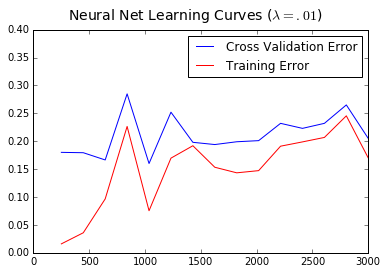

In [99]:
ms = trainfracs_tests * X.shape[0]
fig = plt.figure()
ax =  fig.add_subplot(1,1,1)
cv_line, = ax.plot(list(ms)[0:len(cv_error_vector)], cv_error_vector, color = 'blue')
train_line, = ax.plot(list(ms)[0:len(training_error_vector)],training_error_vector, color='red')
ax.set_ylim([0,.4])
fig.suptitle(r"Neural Net Learning Curves ($\lambda = .01$)", fontsize = 14)
ax.legend([cv_line, train_line], ['Cross Validation Error', 'Training Error'])

In [69]:
len(train_error_vector_lam)

11

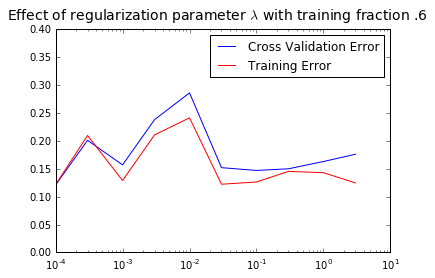

In [79]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line = ax.plot(lamchoices,cv_error_vector_lam, color='blue')
line2 = ax.plot(lamchoices,train_error_vector_lam, color = 'red')
ax.set_xscale('log')
ax.set_ylim([0,.4])
fig.suptitle(r"Effect of regularization parameter $\lambda$ with training fraction .6", fontsize = 14)
ax.legend([cv_line, train_line], ['Cross Validation Error', 'Training Error'])

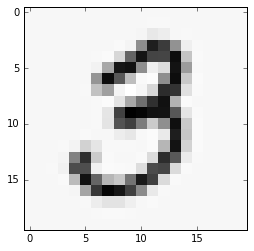

In [125]:
xq = np.reshape(X[10,:],[20, 20], order='F') * 255
plt.imshow(xq, cmap = "Greys", interpolation="nearest")

In [175]:
def visualize_learning(X, y, res, n, il=400, hl=25, ol=10):
    theta_out = res['x']
    split_indx = hl * (il + 1);

    Theta1 = np.reshape(theta_out[0:split_indx], [hl, il + 1])
    Theta2 = np.reshape(theta_out[split_indx:] , [ol, hl + 1] )
    
    preds = predict(Theta1, Theta2, X) + 1
    
    pk = preds[n]
    xvals = X[n,:]
    actual = y[n][0]
    if pk == 10:
        pk = 0
    if actual == 10:
        actual = 0
    x_matrix = np.reshape(xvals, [20, 20], order='F')
    plt.rcParams.update({'font.size': 18})
    plt.imshow(x_matrix, cmap="Greys")
    plt.suptitle("Predicted: " + str(pk) + ", Actual: " + str(actual))
    plt.axis("off")

10285


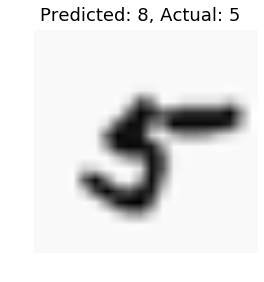

In [366]:
visualize_learning(X_test, y_test, training_results_vector[14], 908)

In [143]:
len(training_results_vector)

15

In [371]:
def gen_histogram(X, y, res, il=400, hl=25, ol=10):
    theta_out = res['x']
    split_indx = hl * (il + 1);

    Theta1 = np.reshape(theta_out[0:split_indx], [hl, il + 1])
    Theta2 = np.reshape(theta_out[split_indx:] , [ol, hl + 1] )
    
    preds = predict(Theta1, Theta2, X) + 1
    
    wrong_actual = []
    wrong_predicted = []
    plt.rcParams.update({'font.size': 14})

    for k, item in enumerate(y):
        pk = preds[k]
        actual = y[k]
        if pk == 10:
            pk = 0
        if actual == 10:
            actual = 0
            
        if pk != actual:
            wrong_predicted.append(pk)
            wrong_actual.append(actual)
    return (wrong_actual, wrong_predicted)

In [372]:
wrong_actual, wrong_predicted = gen_histogram(X, y, training_results_vector[14])

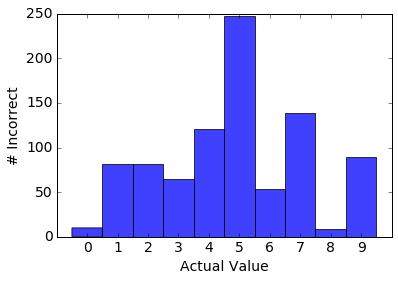

In [373]:
d = np.min(np.diff(np.unique(wrong_actual)))
left_of_first_bin = np.min(wrong_actual) - float(d)/2
right_of_last_bin = np.max(wrong_actual) + float(d)/2
ds = [float(x) for x in wrong_actual]
n, bins, patches = plt.hist(ds, np.arange(left_of_first_bin, right_of_last_bin + d, d), facecolor='blue', alpha=0.75)
plt.xlim([-1,10])
plt.xticks(range(0,10))
plt.xlabel("Actual Value")
plt.ylabel("# Incorrect")

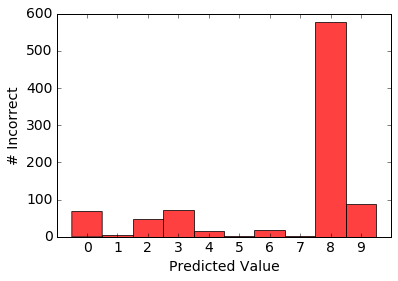

In [374]:
d = np.min(np.diff(np.unique(wrong_predicted)))
left_of_first_bin = np.min(wrong_predicted) - float(d)/2
right_of_last_bin = np.max(wrong_predicted) + float(d)/2
ds = [float(x) for x in wrong_predicted]
n, bins, patches = plt.hist(ds, np.arange(left_of_first_bin, right_of_last_bin + d, d), facecolor='red', alpha=0.75)
plt.xlim([-1,10])
plt.xticks(range(0,10))
plt.xlabel("Predicted Value")
plt.ylabel("# Incorrect")

In [ ]:
len(ds)

In [194]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [277]:
np.bincount(y.flatten())

array([  0, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500])

In [17]:
def train_and_eval(params, INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS, maxiter = 50):
    init_theta1 = rand_init_weights(INPUT_LAYERS, HIDDEN_LAYERS).flatten()
    init_theta2 = rand_init_weights(HIDDEN_LAYERS, OUTPUT_LAYERS).flatten()

    init_params = np.concatenate([init_theta1, init_theta2])
    
    opts = {'disp':True, 'maxiter':maxiter}

    print("Optimizing...")
    res = spo.minimize(cost_function, init_params, method = 'CG', jac = jacobian, args = params, tol = 1e-4, options = opts)
    print("Finished optimization.")

    theta_out = res['x']

    split_indx = HIDDEN_LAYERS * (INPUT_LAYERS + 1);

    Theta1 = np.reshape(theta_out[0:split_indx], [HIDDEN_LAYERS, INPUT_LAYERS + 1])
    Theta2 = np.reshape(theta_out[split_indx:] , [OUTPUT_LAYERS, HIDDEN_LAYERS + 1] )

    # Calculate the training error
    preds_train = predict(Theta1, Theta2, X_train) + 1
    correct = 0;
    total = len(y_train);
    for k in range(0,len(y_train)):
        predic = preds_train[k]
        acts = y_train[k]
        if predic == acts:
            correct += 1
    err_train = 1 - correct/total

    print("Training error: " + str(err_train))
    return (res, err_train)

In [ ]:
INPUT_NEURONS = 400
HIDDEN_NEURONS = 25
OUTPUT_NEURONS = 10
lam = .001
trainfrac = .6

TRAIN_FRACTION = trainfrac
CV_FRACTION = min(trainfrac, .2)
TEST_FRACTION = .2

X = d['X']
np.random.seed(1234)
np.random.shuffle(X)

y = d['y']
np.random.seed(1234)
np.random.shuffle(y)

X_train = X[0:int(np.floor(X.shape[0] * TRAIN_FRACTION)),:]
y_train = y[0:int(np.floor(y.shape[0] * TRAIN_FRACTION)),:]

X_cv = X[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]
y_cv = y[int(np.floor(X.shape[0] * TRAIN_FRACTION)):int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))),:]

X_test = X[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]
y_test = y[int(np.floor(X.shape[0] * (TRAIN_FRACTION + CV_FRACTION))):,:]


params = (INPUT_NEURONS, HIDDEN_NEURONS, OUTPUT_NEURONS, X_train, y_train, lam)
(r1, err_train) = train_and_eval(params, INPUT_NEURONS, HIDDEN_NEURONS, OUTPUT_NEURONS, 50)

Optimizing...


In [21]:
theta_out = r1['x']
split_indx = HIDDEN_NEURONS * (INPUT_NEURONS + 1);
Theta1 = np.reshape(theta_out[0:split_indx], [HIDDEN_NEURONS, INPUT_NEURONS + 1])
Theta2 = np.reshape(theta_out[split_indx:] , [OUTPUT_NEURONS, HIDDEN_NEURONS + 1] )

preds_train = predict(Theta1, Theta2, X_train) + 1
correct = 0;
total = len(y_train);
for k in range(0,len(y_train)):
    predic = preds_train[k]
    acts = y_train[k]
    if predic == acts:
        correct += 1
err_train = 1 - correct/total

print("Training error: " + str(err_train))

Training error: 0.23333333333333328


     fun: 0.20928462080668134
     jac: array([ -4.96692824e-04,   2.32491304e-08,  -3.85841739e-08, ...,
         3.76104461e-04,   4.95604971e-04,  -6.30428498e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 115
     nit: 50
    njev: 115
  status: 1
 success: False
       x: array([-0.4243605 ,  0.06974739, -0.11575252, ..., -1.33263751,
       -3.98387444, -0.80687247])